<a href="https://colab.research.google.com/github/fmathews11/College_Basketball_Functions/blob/main/Pulling_Gameplan_From_Kenpom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kenpompy
!pip install mechanicalsoup
import mechanicalsoup,pandas as pd,numpy as np, warnings,seaborn as sns, matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from kenpompy.utils import login
warnings.filterwarnings("ignore")

In [22]:
browser = login('fmathews@gmail.com','passwordd1')
def get_team_gameplan(browser,team):

  #Pull in HTML
  url = 'https://kenpom.com/gameplan.php?team='+str(team)
  browser.open(url)
  raw_source = browser.get_current_page()
  table = raw_source.find_all('table')
  df = pd.read_html(str(table[0]))[0]

  #Let's Clean it up
  df.columns = [i[0] +  "_" +i[1] for i in df.columns.tolist()]
  df = df.drop([df.columns[i] for i in [1,7,12,14,18]],axis = 1)

  #Column name cleaning
  for i in df.columns:
    if "." in i:
      df = df.rename(columns = {i:i[:-2]})
  for i in df.columns:
    if "Unnamed" in i:
      df = df.rename(columns = {i:i.split()[-1]})
  for i in df.columns:
    if "level" in i:
      df = df.rename(columns = {i:i.split("_")[-1]})


  #Remove Extra Junk From the end
  cutoff_value = np.where(df.Date == "Correlations (R x 100)")[0][0]
  df = df.iloc[:cutoff_value,:]

  #Splitting the results column
  result_vals = [i for i in df.Result.tolist()]
  df.Result = [str(i[0]) for i in result_vals]
  df['Score'] = [str(i.split(',')[-1]) for i in result_vals]

  col_names = ['Date',
              'Opponent',
              'Result',
              'Location',
              'Pace',
              'Offense_Eff',
              'Offense_eFG%',
              'Offense_TO%',
              'Offense_OR%',
              'Offense_FTR',
              'Offense_2P%',
              'Offense_3P%',
              'Offense_3PA%',
              'Defense_Eff',
              'Defense_eFG%',
              'Defense_TO%',
              'Defense_OR%',
              'Defense_FTR',
              'Defense_2P',
              'Defense_2P%',
              'Defense_3P',
              'Defense_3P%',
              'Defense_3PA%',
              'Score']
  df.columns = col_names
  df.Result = df.Result.map({"W":1,"L":0})

  #Coerce all strings to numeric type for computation
  for i in df.columns:
   try:
     df[i] = pd.to_numeric(df[i])
   except:
     continue

  return df


In [14]:
df = get_team_gameplan(browser,'Purdue')
df

,Date,Opponent,Result,Location,Pace,Offense_Eff,Offense_eFG%,Offense_TO%,Offense_OR%,Offense_FTR,Offense_2P%,Offense_3P%,Offense_3PA%,Defense_Eff,Defense_eFG%,Defense_TO%,Defense_OR%,Defense_FTR,Defense_2P,Defense_2P%,Defense_3P,Defense_3P%,Defense_3PA%,Score
0,Tue Nov 9,Bellarmine,1,H,67,143.7,64.3,19.5,50.0,51.8,60.0,44.4,64.3,100.3,50.9,15.0,20.6,13.6,12-24,50.0,12-35,34.3,59.3,96-67
1,Fri Nov 12,Indiana St.,1,H,73,126.2,60.3,16.5,36.4,55.2,60.5,40.0,34.5,91.9,43.8,16.5,25.0,21.9,19-38,50.0,6-26,23.1,40.6,92-67
2,Tue Nov 16,Wright St.,1,H,75,128.3,60.5,22.7,52.8,31.3,61.5,39.3,41.8,69.5,34.8,20.1,13.9,23.7,13-33,39.4,5-26,19.2,44.1,96-52
3,Sat Nov 20,North Carolina,1,N,77,121.5,63.9,11.8,13.8,36.1,63.2,43.5,37.7,109.7,53.6,18.3,30.8,17.4,19-40,47.5,12-29,41.4,42.0,93-84
4,Sun Nov 21,Villanova,1,N,60,132.5,61.8,18.2,42.9,25.4,59.4,43.5,41.8,122.6,56.0,6.6,27.8,29.3,13-24,54.2,13-34,38.2,58.6,80-74
5,Fri Nov 26,Nebraska Omaha,1,H,67,145.5,65.2,18.0,50.0,40.7,59.5,52.9,28.8,60.0,30.9,13.5,17.0,3.2,12-35,34.3,5-28,17.9,44.4,97-40
6,Tue Nov 30,Florida St.,1,H,68,136.3,69.5,19.1,41.7,23.7,67.6,48.0,42.4,95.2,47.6,19.1,29.7,9.5,18-39,46.2,8-24,33.3,38.1,93-65
7,Fri Dec 3,Iowa,1,H,76,101.3,50.0,22.4,25.0,74.0,41.9,42.1,38.0,92.1,44.4,11.8,15.0,35.5,20-41,48.8,5-21,23.8,33.9,77-70
8,Thu Dec 9,Rutgers,0,A,66,103.7,46.7,16.8,42.1,26.2,51.4,26.9,42.6,106.8,59.4,24.4,20.8,37.5,18-34,52.9,7-14,50.0,29.2,70-68
9,Sun Dec 12,N.C. State,1,N,67,109.3,54.2,18.7,32.4,41.7,64.1,23.8,35.0,96.0,48.4,17.3,17.9,24.2,18-41,43.9,8-21,38.1,33.9,82-72


In [15]:
import kenpompy.summary as kp
sum_df = kp.get_efficiency(browser,2022)
sum_df_ = sum_df.copy()
sum_df[sum_df.Team == 'Purdue']

,Team,Conference,Tempo-Adj,Tempo-Adj.Rank,Tempo-Raw,Tempo-Raw.Rank,Avg. Poss Length-Offense,Avg. Poss Length-Offense.Rank,Avg. Poss Length-Defense,Avg. Poss Length-Defense.Rank,Off. Efficiency-Adj,Off. Efficiency-Adj.Rank,Off. Efficiency-Raw,Off. Efficiency-Raw.Rank,Def. Efficiency-Adj,Def. Efficiency-Adj.Rank,Def. Efficiency-Raw,Def. Efficiency-Raw.Rank
239,Purdue,B10,66.6,230,67.1,240,17.6,188,18.1,295,123.3,1,120.8,1,99.3,102,101.2,167


In [18]:
target_df = df[['Date','Opponent','Defense_3P%','Result']]
target_df.head()

,Date,Opponent,Defense_3P%,Result
0,Tue Nov 9,Bellarmine,34.3,1
1,Fri Nov 12,Indiana St.,23.1,1
2,Tue Nov 16,Wright St.,19.2,1
3,Sat Nov 20,North Carolina,41.4,1
4,Sun Nov 21,Villanova,38.2,1


In [29]:
stats_df = kp.get_teamstats(browser,2022)
target_df['3_season_average'] = target_df.Opponent.map(dict(zip(stats_df.Team,stats_df['3P%']))).astype(float)
target_df['3pt_differential'] = target_df['Defense_3P%'] - target_df['3_season_average']
target_df

,Date,Opponent,Defense_3P%,Result,3_season_average,3pt_differential
0,Tue Nov 9,Bellarmine,34.3,1,34.2,0.1
1,Fri Nov 12,Indiana St.,23.1,1,36.1,-13.0
2,Tue Nov 16,Wright St.,19.2,1,34.1,-14.9
3,Sat Nov 20,North Carolina,41.4,1,35.0,6.4
4,Sun Nov 21,Villanova,38.2,1,31.3,6.9
5,Fri Nov 26,Nebraska Omaha,17.9,1,39.8,-21.9
6,Tue Nov 30,Florida St.,33.3,1,37.0,-3.7
7,Fri Dec 3,Iowa,23.8,1,32.8,-9.0
8,Thu Dec 9,Rutgers,50.0,0,34.2,15.8
9,Sun Dec 12,N.C. State,38.1,1,36.6,1.5


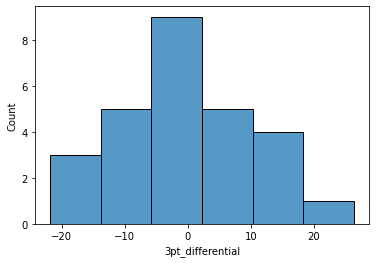

In [31]:
sns.histplot(target_df['3pt_differential']);

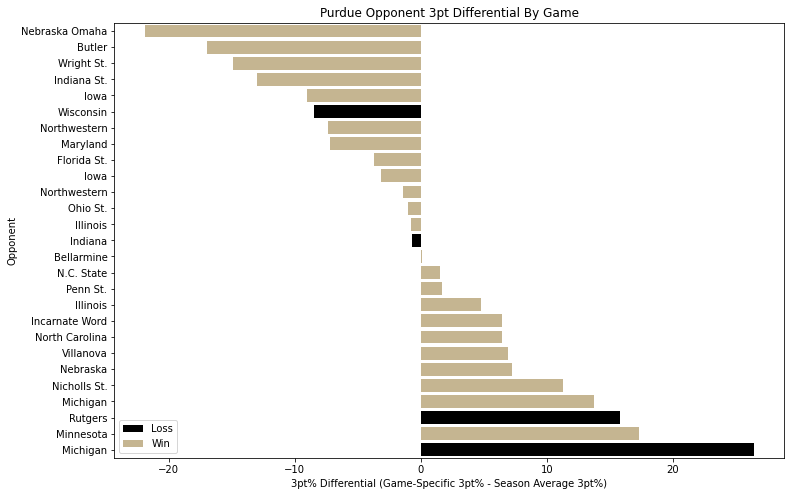

In [36]:
plt.figure(figsize = (12,8))
g = sns.barplot(data = target_df.sort_values('3pt_differential'),
            x = "3pt_differential",
            y = 'Date',
            hue = 'Result',
            orient = "h",
            dodge = False,
            ci = None,
            palette = ["#000000","#CEB888"])
plt.legend(labels = ['Loss','Win'])
plt.title("Purdue Opponent 3pt Differential By Game",size = 12)
plt.xlabel("3pt% Differential (Game-Specific 3pt% - Season Average 3pt%)")
plt.yticks(ticks = [i for i in range(len(target_df))],labels = target_df.sort_values('3pt_differential').Opponent)
plt.ylabel("Opponent")
plt.show();

In [37]:
team_1 = 'Purdue'
team_2 = 'Rutgers'

sum_df = sum_df_.copy()
for i in sum_df.columns:
  try:
    sum_df[i] = pd.to_numeric(sum_df[i])
  except:
    pass
sum_df.columns = ['_'.join(i.split()) for i in sum_df.columns.tolist()]
sum_df.columns = [i.replace(".","") for i in sum_df.columns]
sum_df.columns = [i.replace("-","_") for i in sum_df.columns]
off_eff_avg = round(sum_df.Off_Efficiency_Adj.mean(),2)
def_eff_avg = round(sum_df.Def_Efficiency_Adj.mean(),2)

team_1_off_eff = sum_df.loc[sum_df.Team == team_1].Off_Efficiency_Adj.item()
team_1_def_eff = sum_df.loc[sum_df.Team == team_1].Def_Efficiency_Adj.item()
team_2_off_eff = sum_df.loc[sum_df.Team == team_2].Off_Efficiency_Adj.item()
team_2_def_eff = sum_df.loc[sum_df.Team == team_2].Def_Efficiency_Adj.item()
team_1_tempo = sum_df.loc[sum_df.Team == team_1].Tempo_Adj.item()
team_2_tempo = sum_df.loc[sum_df.Team == team_2].Tempo_Adj.item()

team_1_off_pct = (team_1_off_eff/off_eff_avg)-1
team_1_off_pct_adjustment_factor = 1+round(team_1_off_pct + ((team_2_def_eff/def_eff_avg) - 1),2)
team_1_off_adj = round(off_eff_avg * team_1_off_pct_adjustment_factor,2)
print(f"{team_1}'s expected efficiency is {team_1_off_adj}")

team_2_off_pct = (team_2_off_eff/off_eff_avg)-1
team_2_off_pct_adjustment_factor = 1+round(team_2_off_pct + ((team_1_def_eff/def_eff_avg) - 1),2)
team_2_off_adj = round(off_eff_avg * team_2_off_pct_adjustment_factor,2)
print(f"{team_2}'s expected efficiency is {team_2_off_adj}")
print(f"{team_1} averages {round(team_1_tempo)} possessions per game")
print(f"{team_2} averages {round(team_2_tempo)} possessions per game")
print(f"{team_1} is therefore expected to score {round((team_1_tempo)*(team_1_off_adj/100)+3.75)} points")
print(f"{team_2} is therefore expected to score {round((team_2_tempo)*(team_2_off_adj/100))} points")

Purdue's expected efficiency is 115.53
Rutgers's expected efficiency is 102.12
Purdue averages 67 possessions per game
Rutgers averages 65 possessions per game
Purdue is therefore expected to score 81 points
Rutgers is therefore expected to score 67 points


,Team,Conference,Tempo_Adj,Tempo_AdjRank,Tempo_Raw,Tempo_RawRank,Avg_Poss_Length_Offense,Avg_Poss_Length_OffenseRank,Avg_Poss_Length_Defense,Avg_Poss_Length_DefenseRank,Off_Efficiency_Adj,Off_Efficiency_AdjRank,Off_Efficiency_Raw,Off_Efficiency_RawRank,Def_Efficiency_Adj,Def_Efficiency_AdjRank,Def_Efficiency_Raw,Def_Efficiency_RawRank
